In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! chmod 600 '/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/DATASET/kaggle.json'

In [ ]:
! KAGGLE_CONFIG_DIR='/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/DATASET/' kaggle competitions download -c paddy-disease-classification

 99% 1.01G/1.02G [00:10<00:00, 109MB/s]
100% 1.02G/1.02G [00:11<00:00, 99.3MB/s]


In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/paddy-disease-classification.zip')
zip_file.extractall('/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/DATASET/Padi')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/DATASET/Padi/train.csv')
df.shape

(10407, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


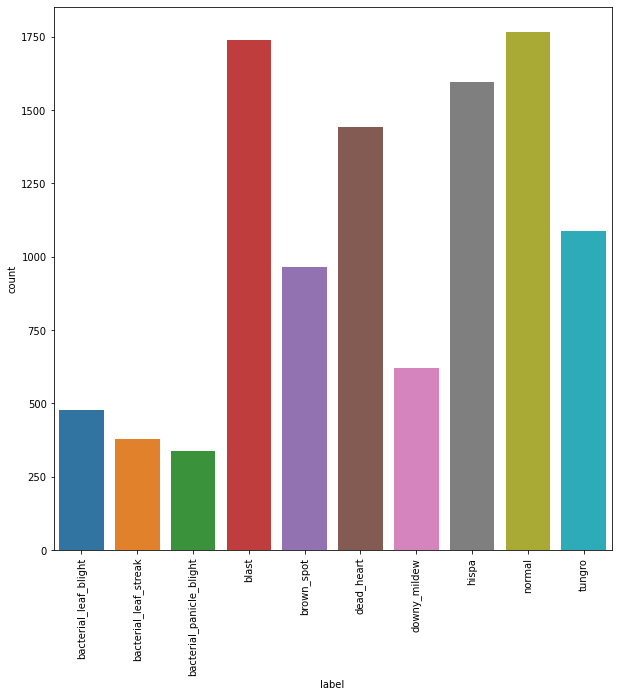

In [ ]:
plt.figure(figsize=(10,10))
sb.countplot(df['label'])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configure variables for Transfer learning
image_size = 256
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 64

In [ ]:
dataset_root = "/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/DATASET/Padi"

train_dir = os.path.join(dataset_root, "train_images")
test_dir = os.path.join(dataset_root, "test_images")
labels = os.listdir(train_dir)

In [ ]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size = target_size,
    batch_size = batch_size,
    shuffle=True,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.2,
    subset='training',
    seed=40
)

val_dataset = image_dataset_from_directory(
    train_dir,
    image_size = target_size,
    batch_size = batch_size,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.2,
    subset='validation',
    seed=40
)

Found 18870 files belonging to 10 classes.
Using 15096 files for training.
Found 18870 files belonging to 10 classes.
Using 3774 files for validation.


In [ ]:
test_dataset = image_dataset_from_directory(    
    test_dir,
    image_size = target_size,
    batch_size = 64,
    shuffle=False,
    labels=None,
    class_names = None,
    label_mode = None,
    color_mode='rgb',
)

Found 3469 files belonging to 1 classes.


## **Modelling**

In [ ]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(weights="imagenet",
                                          include_top=False,
                                          input_shape=input_shape)

# Stop from being trainable
mbnet_v2.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(len(labels), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096  

In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

## **Training Model**

In [ ]:
%%time
# Num epochs
epochs = 30

# Train model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    callbacks=[early_stopping_cb])

Epoch 1/30
235/235 [==============================] - 1490s 6s/step - loss: 1.8836 - accuracy: 0.3635 - val_loss: 1.7126 - val_accuracy: 0.3932
Epoch 2/30
235/235 [==============================] - 85s 354ms/step - loss: 1.4497 - accuracy: 0.5130 - val_loss: 1.4863 - val_accuracy: 0.5295
Epoch 3/30
235/235 [==============================] - 84s 351ms/step - loss: 1.2278 - accuracy: 0.5906 - val_loss: 0.9520 - val_accuracy: 0.6881
Epoch 4/30
235/235 [==============================] - 84s 350ms/step - loss: 1.0823 - accuracy: 0.6476 - val_loss: 0.9496 - val_accuracy: 0.6977
Epoch 5/30
235/235 [==============================] - 84s 350ms/step - loss: 0.9593 - accuracy: 0.6846 - val_loss: 1.1044 - val_accuracy: 0.6606
Epoch 6/30
235/235 [==============================] - 84s 349ms/step - loss: 0.8406 - accuracy: 0.7276 - val_loss: 1.1622 - val_accuracy: 0.6401
Epoch 7/30
235/235 [==============================] - 84s 350ms/step - loss: 0.7872 - accuracy: 0.7468 - val_loss: 0.9225 - val_acc

In [ ]:
model.save("/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/MODELING/penyakit_padi_detection3.h5")

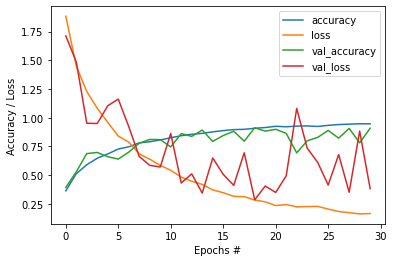

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/MODELING/penyakit_padi_detection2.h5")

In [ ]:
model.evaluate(val_dataset)

59/59 [==============================] - 18s 302ms/step - loss: 0.3825 - accuracy: 0.9088


[0.3824591338634491, 0.9088243246078491]

## **Prediction**

In [ ]:
predictions = model.predict(test_dataset)
predictions.shape

(3469, 10)

In [ ]:
ss = pd.read_csv('/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/DATASET/Padi/sample_submission.csv')
ss['label'] = np.argmax(predictions, axis=-1)
ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], labels)
ss.T

,0,1,2,3,4,5,6,7,8,9,...,3459,3460,3461,3462,3463,3464,3465,3466,3467,3468
image_id,200001.jpg,200002.jpg,200003.jpg,200004.jpg,200005.jpg,200006.jpg,200007.jpg,200008.jpg,200009.jpg,200010.jpg,...,203460.jpg,203461.jpg,203462.jpg,203463.jpg,203464.jpg,203465.jpg,203466.jpg,203467.jpg,203468.jpg,203469.jpg
label,downy_mildew,normal,blast,blast,blast,blast,dead_heart,hispa,brown_spot,normal,...,normal,normal,bacterial_panicle_blight,normal,bacterial_leaf_blight,dead_heart,hispa,hispa,bacterial_leaf_streak,dead_heart


In [ ]:
ss.to_csv('hasil_model2.csv', index=False)

## **Modelling 2**

In [ ]:
# Load the base model
base_model2 = keras.applications.InceptionV3(weights="imagenet",
                                                   include_top=False,
                                                   input_shape=input_shape)

# Stop from being trainable
base_model2.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = base_model2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(len(labels), activation="softmax")(x)

# Combine the model
model2 = Model(inputs=inputs, outputs=x)

# Summary
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_94 (Bat  (None, 1024)             4096      
 chNormalization)                                            

In [ ]:
# Compile
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

## **Training Model 2**

In [ ]:
%%time
# Num epochs
epochs = 30
 
# Train model
history = model2.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    callbacks=[early_stopping_cb])

Epoch 1/30
472/472 [==============================] - 2447s 5s/step - loss: 2.3020 - accuracy: 0.1966 - val_loss: 2.0549 - val_accuracy: 0.2157
Epoch 2/30
472/472 [==============================] - 2378s 5s/step - loss: 2.0408 - accuracy: 0.2810 - val_loss: 1.8663 - val_accuracy: 0.3050
Epoch 3/30
472/472 [==============================] - 2372s 5s/step - loss: 1.9158 - accuracy: 0.3364 - val_loss: 2.1443 - val_accuracy: 0.1566
Epoch 4/30
472/472 [==============================] - 2395s 5s/step - loss: 1.8524 - accuracy: 0.3637 - val_loss: 2.1775 - val_accuracy: 0.1812
Epoch 5/30
472/472 [==============================] - 2387s 5s/step - loss: 1.7903 - accuracy: 0.3925 - val_loss: 1.2007 - val_accuracy: 0.5938
Epoch 6/30
472/472 [==============================] - 2396s 5s/step - loss: 1.7171 - accuracy: 0.4227 - val_loss: 1.6723 - val_accuracy: 0.3622
Epoch 7/30
472/472 [==============================] - 2393s 5s/step - loss: 1.6515 - accuracy: 0.4499 - val_loss: 1.9746 - val_accuracy:

In [ ]:
model2.save("/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/MODELING/penyakit_padi_detection4.h5")

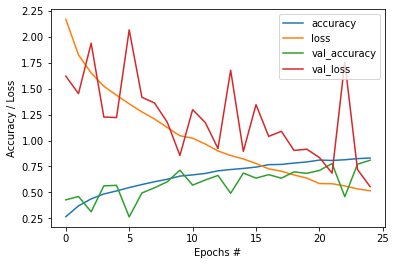

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [ ]:
model2.evaluate(val_dataset)

54/54 [==============================] - 16s 294ms/step - loss: 0.5547 - accuracy: 0.8103


[0.5546970963478088, 0.8103448152542114]

## **Prediction 2**

In [ ]:
predictions = model2.predict(test_dataset)
predictions.shape

(3469, 10)

In [ ]:
ss2 = pd.read_csv('/content/drive/MyDrive/SEM 6 - MBKM/PROYEK AKHIR/DATASET/Padi/sample_submission.csv')
ss2['label'] = np.argmax(predictions, axis=-1)
ss2['label'] = ss2['label'].replace([0,1,2,3,4,5,6,7,8,9], labels)
ss2.T

,0,1,2,3,4,5,6,7,8,9,...,3459,3460,3461,3462,3463,3464,3465,3466,3467,3468
image_id,200001.jpg,200002.jpg,200003.jpg,200004.jpg,200005.jpg,200006.jpg,200007.jpg,200008.jpg,200009.jpg,200010.jpg,...,203460.jpg,203461.jpg,203462.jpg,203463.jpg,203464.jpg,203465.jpg,203466.jpg,203467.jpg,203468.jpg,203469.jpg
label,downy_mildew,normal,hispa,blast,tungro,hispa,dead_heart,normal,hispa,normal,...,normal,normal,bacterial_panicle_blight,normal,bacterial_leaf_streak,dead_heart,hispa,normal,bacterial_leaf_streak,dead_heart
